# Example 2: running GLMsingle on localizer data from the Natural Scenes Dataset

In [10]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

# Step 1: load fMRI dataset

In [11]:
homedir = split(os.getcwd())[0]

datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

datafn = join(datadir,'nsdflocexampledataset.mat')

print(f'directory to save example dataset:\n{datadir}')

directory to save example dataset:
/Volumes/T7/research/projects/GLMsingle/examples/data


In [12]:
# Data comes from subject1, fLoc session from NSD dataset.
# https://www.biorxiv.org/content/10.1101/2021.02.22.432340v1.full.pdf
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    dataurl = 'https://osf.io/g42tm/download'
    
    # download the .mat file to the specified director
    urllib.request.urlretrieve(dataurl, datafn)
    
# load struct containing example dataset
X = sio.loadmat(datafn)

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]


In [13]:
data = []
design = []

nruns = len(X['data'][0])

# iterate through each run of data
for r in range(nruns):
    
    # index into struct, append each run's timeseries data to list
    data.append(X['data'][0,r])
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
print('Shape of data from one run is:\n',data[0].shape)
xyz = data[0].shape[:3]

Shape of data from one run is:
 (52, 81, 42, 234)


data -> consists of several runs of 4D volume files (x,y,z,t) where (t)ime is the 4th dimention. In this example data consists of only a single slice and has been prepared with a TR = 1s

# visualize data and design matrix

In [14]:
print(f'data has {len(data)} runs')
print(f'shape of data from each run is: {data[0].shape}')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only)')
print(f'n = {data[0].shape[3]} TRs per run')
print(f'type of data is: {type(data[0][0,0,0,0])}')

data has 4 runs
shape of data from each run is: (52, 81, 42, 234)
XYZ dimensionality is: (52, 81, 42) (one slice only)
n = 234 TRs per run
type of data is: <class 'numpy.float32'>


Text(0, 0.5, 'time (TR)')

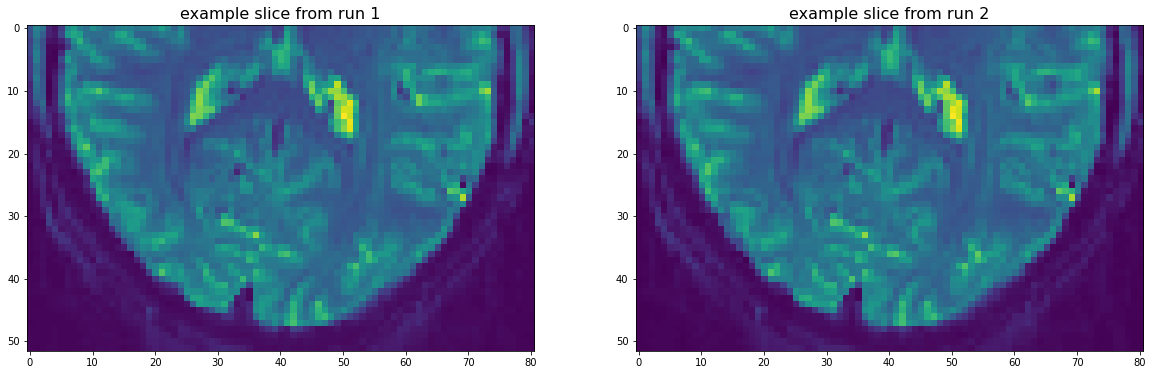

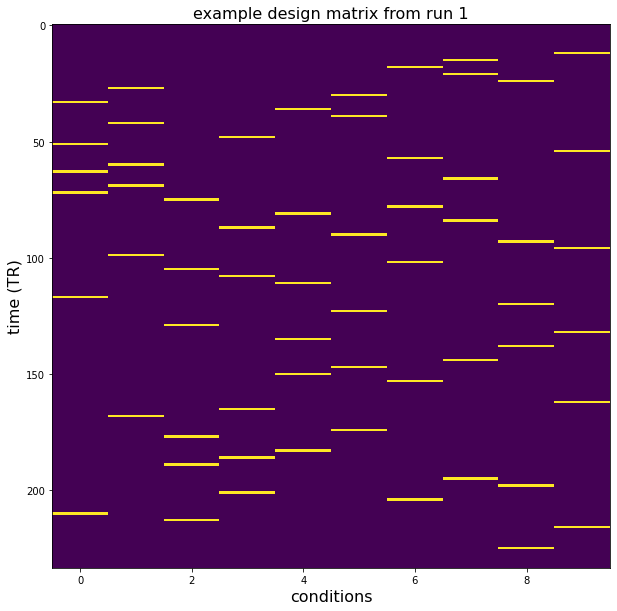

In [15]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,20,0])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[1][:,:,20,0])
plt.title('example slice from run 2',fontsize=16)

plt.figure(figsize=(10,10))
plt.imshow(design[0],aspect='auto',interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16)

design -> Each run has a corresponding design matrix where each column
describes a single condition (conditions are repeated across runs). 
Each design matrix is binary with 1 specfing the time (TR) when the stimulus 
is presented on the screen.

In this NSD fLOC session there were 10 distinct images shown and hence
there are 10 predictor columns/conditions. Notice that the rectangles
are pseudo randomized and they indicate when the presentaion of each
image occurs. Details of the stimulus are described here
https://github.com/VPNL/fLoc

# Step 2: Run baseline GLM (canonical HRF and no optimizations) using GLMsingle

In [16]:
outputdir_baseline = join(homedir,'examples','example2outputs','GLMbaseline')

opt = dict()

# for comparison purposes we are going to run a standard GLM
# without HRF fitting, GLMdenoise or ridge regression regularization. We
# will change the default settings by using the "opt" structure.
opt['wantlibrary'] = 0
opt['wantglmdenoise'] = 0
opt['wantfracridge'] = 0
opt['wantfileoutputs'] = [1,1,0,0]

# For the purpose of this example we will keep the relevant outputs in memory
opt['wantmemoryoutputs'] = [1,1,0,0]

start_time = time.time()

# create GLM_single object
gst_assumehrf = GLM_single(opt)

pprint(gst_assumehrf.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1627027369.1023428,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 0, 0],
 'wantfracridge': 0,
 'wantglmdenoise': 0,
 'wantlibrary': 0,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 0, 0],
 'wantparametric': 0,
 'wantpercentbold': 1}


- Outputs and figures will be stored in a folder (you can specify it's name 
as the 5th output to GLMestimatesingletrial.) Model estimates can be also
saved to the results variable which is the only output of 
GLMestimatesingletrial

- Optional parameters below can be assigned to a strucutre i.e
opt = struct('wantlibrary',1,'wantglmdenoise',1); Options are the 6th  
input to GLMestimatesingletrial.

- DEFAULT OPTIONS:

    - wantlibrary = 1 -> Fit HRF to each voxel
    - wantglmdenoise = 1 -> Use GLMdenoise
    - wantfracridge = 1  -> Use ridge regression to improve beta estimates
    - chunknum = 50000 -> is the number of voxels that we will process at the same time. For setups with lower memory deacrease this number.
    - wantmemoryoutputs is a logical vector [A B C D] indicating which of the four model types to return in the output <results>. The user must be careful with this, as large datasets can require a lot of RAM. If you
do not request the various model types, they will be cleared from 
memory (but still potentially saved to disk). Default: [0 0 0 1] which means return only the final type-D model.

    - wantfileoutputs is a logical vector [A B C D] indicating which of the four model types to save to disk (assuming that they are computed).
        - A = 0/1 for saving the results of the ONOFF model
        - B = 0/1 for saving the results of the FITHRF model
        - C = 0/1 for saving the results of the FITHRF_GLMdenoise model
        - D = 0/1 for saving the results of the FITHRF_GLMdenoise_RR model
        - Default: [1 1 1 1] which means save all computed results to disk.

    - numpcstotry (optional) is a non-negative integer indicating the maximum
number of PCs to enter into the model. Default: 10.

    - fracs (optional) is a vector of fractions that are greater than 0
and less than or equal to 1. We automatically sort in descending 
order and ensure the fractions are unique. These fractions indicate 
the regularization levels to evaluate using fractional ridge 
regression (fracridge) and cross-validation. Default: 
fliplr(.05:.05:1). A special case is when <fracs> is specified as a 
single scalar value. In this case, cross-validation is NOT performed 
for the type-D model, and we instead blindly use the supplied 
fractional value for the type-D model.

In [17]:
# Check for existing output; load if possible, else run GLMsingle
if not exists(outputdir_baseline):

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = gst_assumehrf.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_baseline)

    elapsed_time = time.time() - start_time
    print(
        'elapsed time: ',
        f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
    )
else:
    results_assumehrf = dict()
    results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()

    # get shape of output betas for later reference
    xyzn = (xyz[0],xyz[1],xyz[2],results_assumehrf['typeb']['betasmd'].shape[1])

# Step 3: Visualize baseline GLM outputs

In [18]:
meanvol = results_assumehrf['typeb']['meanvol'].reshape(xyz)

brainmask = meanvol > 250

onoffR2 = results_assumehrf['typea']['onoffR2'].reshape(xyz)
onoffR2[~brainmask] = np.nan

meanbetas = np.mean(results_assumehrf['typeb']['betasmd'].reshape(xyzn),axis=3)
meanbetas[~brainmask] = np.nan


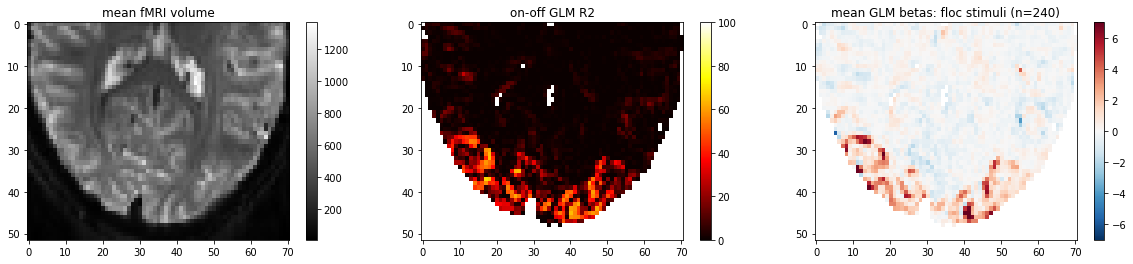

In [19]:
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.imshow(meanvol[:,5:-5,20],aspect='auto',cmap='gray')
plt.colorbar()
plt.title('mean fMRI volume')
plt.subplot(132)
plt.imshow(onoffR2[:,5:-5,20],aspect='auto',clim=(0,100),cmap='hot')
plt.colorbar()
plt.title('on-off GLM R2')
plt.subplot(133)
plt.imshow(meanbetas[:,5:-5,20],aspect='auto',clim=(-7,7),cmap='RdBu_r')
plt.colorbar()
plt.title('mean GLM betas: floc stimuli (n=240)');


# Step 4: Run GLMsingle with optimizations (library of HRFs, GLMdenoise, fractional ridge regression)

In [20]:
data = []
design = []

for r in range(nruns):
    data.append(X['data'][0,r])
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
print(data[0].shape)

(52, 81, 42, 234)


In [21]:
outputdir_glmsingle = join(homedir,'examples','example2outputs','GLMsingle')

opt = dict()
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

start_time = time.time()
gst_glmsingle = GLM_single(opt)

pprint(gst_glmsingle.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1627027369.1023428,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [22]:
if not exists(outputdir_glmsingle):

    # run GLMsingle
    results_glmsingle = gst_glmsingle.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)

    elapsed_time = time.time() - start_time
    print(
        'elapsed time: ',
        f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
    )
    
else:
    results_glmsingle = dict()
    results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()
    


# Step 5: gather different beta versions, compare split-half reliability

To compare the results of different GLMs we are going to calculate the
voxel-wise split-half reliablity for each model. The reliability values
reflect a correlation between beta weights for repeated presentations
of the same stimuli. In short, we are going to check how
reliable/reproducible are single trial responses to repeated images
estimated with each GLM type.

In the code below, we are attempting to locate the
indices in the beta weight GLMsingle outputs modelmd(x,y,z,trials) that
correspond to repated conditions.

In [23]:
models = dict()
models['assumehrf'] = results_assumehrf['typeb']['betasmd'].reshape(xyzn)
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

# Now, "models" variable holds solutions for 4 GLM models

In [24]:
# consolidate design matrices
designALL = np.concatenate(design,axis=0)

# compute a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)
corder[:3]

array([9, 7, 6])

In [25]:
# In order to compute split-half reliability, we have to do some indexing.
# We want to find all repetitions of the same condition. For example we can
# look up when during the 4 blocks image 1 was repeated. Each condition should
# be repeated exactly 24 times.

repindices = []

for p in range(designALL.shape[1]):
    temp = np.argwhere(corder==p)[:,0]
    if len(temp) >= 2:
        repindices.append(temp)

repindices = np.vstack(np.array(repindices)).T      

print(f'there are {repindices.shape[1]} repeated conditions in the experiment')
print(f'there are {repindices.shape[0]} instances of each repeated condition')

there are 10 repeated conditions in the experiment
there are 24 instances of each repeated condition


In [26]:
V1_roi = X['visual'].item()[0] == 1   # for V1
FFA_roi = X['floc'].item()[0] == 2    # for FFA-1

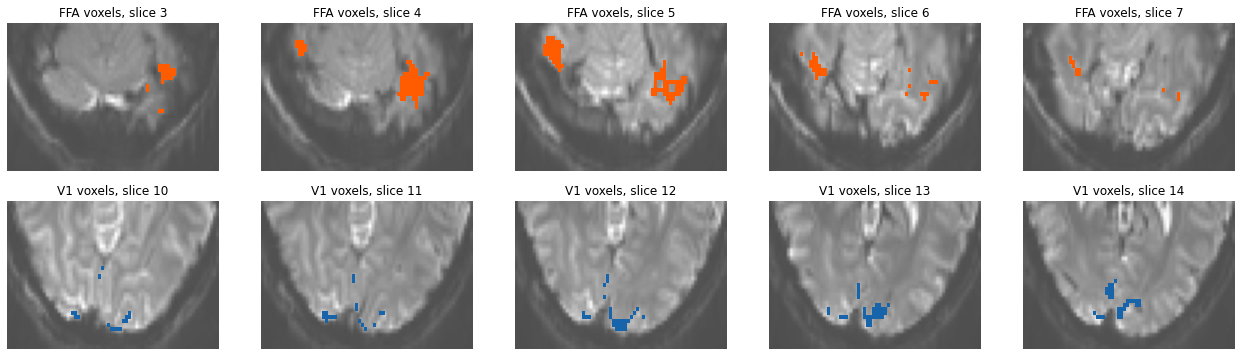

In [18]:
plt.figure(figsize=(22,6))
c=1

FFA_roi_ = np.full(FFA_roi.shape, np.nan)
FFA_roi_[FFA_roi] = 1

V1_roi_ = np.full(V1_roi.shape, np.nan)
V1_roi_[V1_roi] = 1

for s in range(3,8):
    plt.subplot(2,5,c)
    plt.imshow(meanvol[15:,5:-5,s]/np.nanmax(meanvol[15:,5:-5,s]),aspect='auto',cmap='gray',clim=(0,1), alpha=0.7)
    plt.imshow(FFA_roi_[15:,5:-5,s],aspect='auto',cmap='hot',clim=(0,2))
    plt.title('FFA voxels, slice ' + str(s))
    plt.box(False)
    plt.axis(False)
    c+=1

for s in range(10,15):
    plt.subplot(2,5,c)
    plt.imshow(meanvol[15:,5:-5,s]/np.nanmax(meanvol[15:,5:-5,s]),aspect='auto',cmap='gray',clim=(0,1), alpha=0.7)
    plt.imshow(V1_roi_[15:,5:-5,s],aspect='auto',cmap='Blues',clim=(0,1.25))
    plt.title('V1 voxels, slice ' + str(s))
    plt.box(False)
    plt.axis(False)
    c+=1
    

In [19]:
# To calculate the split-half reliability we are going to average the odd
# and even beta weights extracted from the same condition and calculate the
# correlation coefficent between these values. We do this for each voxel
# inside two visual ROIs.

vox_reliabilities = []
modelnames = list(models.keys())
n_cond = repindices.shape[1]

for m in range(len(modelnames)):
    print(modelnames[m])
    time.sleep(1)
    
    # for each GLM under comparison, arrange the betas by (X,Y,Z,repeats,conditions)
    betas = models[modelnames[m]][:,:,:,repindices]
    x,y,z = betas.shape[:3] 
    
    # create output volume for voxel reliability scores
    rels = np.full((x,y,z),np.nan)
    
    # iterate through voxels...
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):
                
                # process only if within ROIs of interest
                if FFA_roi[xx,yy,zz] or V1_roi[xx,yy,zz]: 
                    
                    # for this voxel, get beta matrix of (repeats,conditions)
                    vox_data = betas[xx,yy,zz]
                    
                    # average odd and even betas after shuffling
                    even_data = np.nanmean(vox_data[::2],axis=0)
                    odd_data = np.nanmean(vox_data[1::2],axis=0)

                    # compute split-half reliability and store
                    rels[xx,yy,zz] = np.corrcoef(even_data,odd_data)[1,0]
          
    vox_reliabilities.append(rels)


assumehrf


100%|██████████| 52/52 [00:01<00:00, 38.79it/s] 


fithrf


100%|██████████| 52/52 [00:01<00:00, 39.47it/s] 


fithrf_glmdenoise


100%|██████████| 52/52 [00:02<00:00, 25.98it/s] 


fithrf_glmdenoise_rr


100%|██████████| 52/52 [00:02<00:00, 22.29it/s]


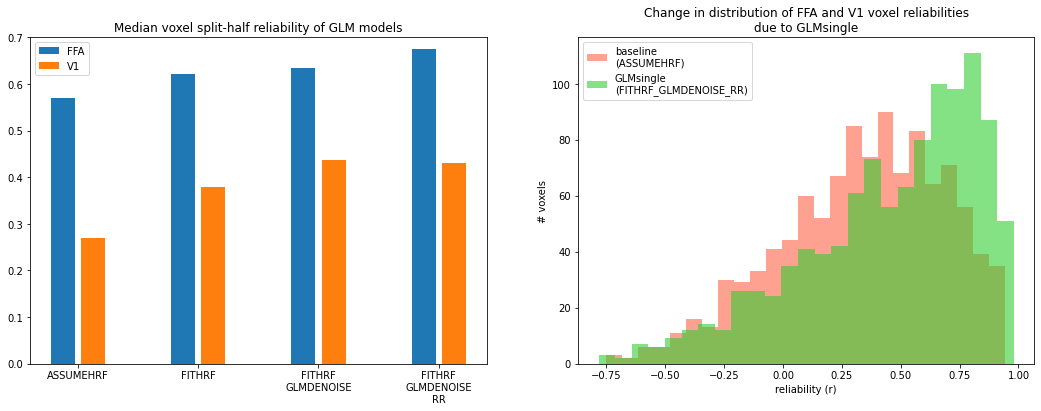

In [49]:
# For each GLM type we will calculate median reliability for voxels within the
# visual ROIs and draw a bar plot for FFA and V1, and histograms showing the improvement from GLMsingle

comparison = []
for vr in vox_reliabilities:
    comparison.append([np.nanmedian(vr[FFA_roi]), np.nanmedian(vr[V1_roi])])
comparison = np.vstack(comparison)

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison[:,0]))-0.125,comparison[:,0],width=0.2)
plt.bar(np.arange(len(comparison[:,1]))+0.125,comparison[:,1],width=0.2)
plt.ylim([0,0.7])

plt.legend(['FFA','V1'])
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(4),np.array(['ASSUMEHRF', 'FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']));

plt.subplot(122)
plt.hist(vox_reliabilities[0].reshape(-1),25,alpha=0.6,color='tomato');
plt.hist(vox_reliabilities[3].reshape(-1),25,alpha=0.6,color='limegreen');
plt.xlabel('reliability (r)')
plt.ylabel('# voxels')
plt.legend(['baseline\n(ASSUMEHRF)', 'GLMsingle\n(FITHRF_GLMDENOISE_RR)'])
plt.title('Change in distribution of FFA and V1 voxel reliabilities\ndue to GLMsingle');


This localizer dataset provides an interesting test case for GLMsingle, since the design is a block structure containing different stimuli from the same domain presented rapidly in time within each block. The fact that GLMsingle confers clear benefit in both a low-level visual region (V1) and a higher-level region (FFA) is notable. Moreover, it is reasonable to expect that overall reliability would be higher in FFA, since that ROI may yield responses that are more category-invariant than those in V1, and the optimizations within GLMsingle treat all images within a localizer block as the "same" condition, even though there are different images comprising each block. As such, it makes sense that voxels in FFA (with larger receptive fields and more category invariance) would show higher reliability using the split-half metric than those in V1.

### slice view: change in voxel reliability due to GLMsingle
#### plotting (FITHRF_GLMDENOISE_RR - ASSUMEHRF) reliabilities

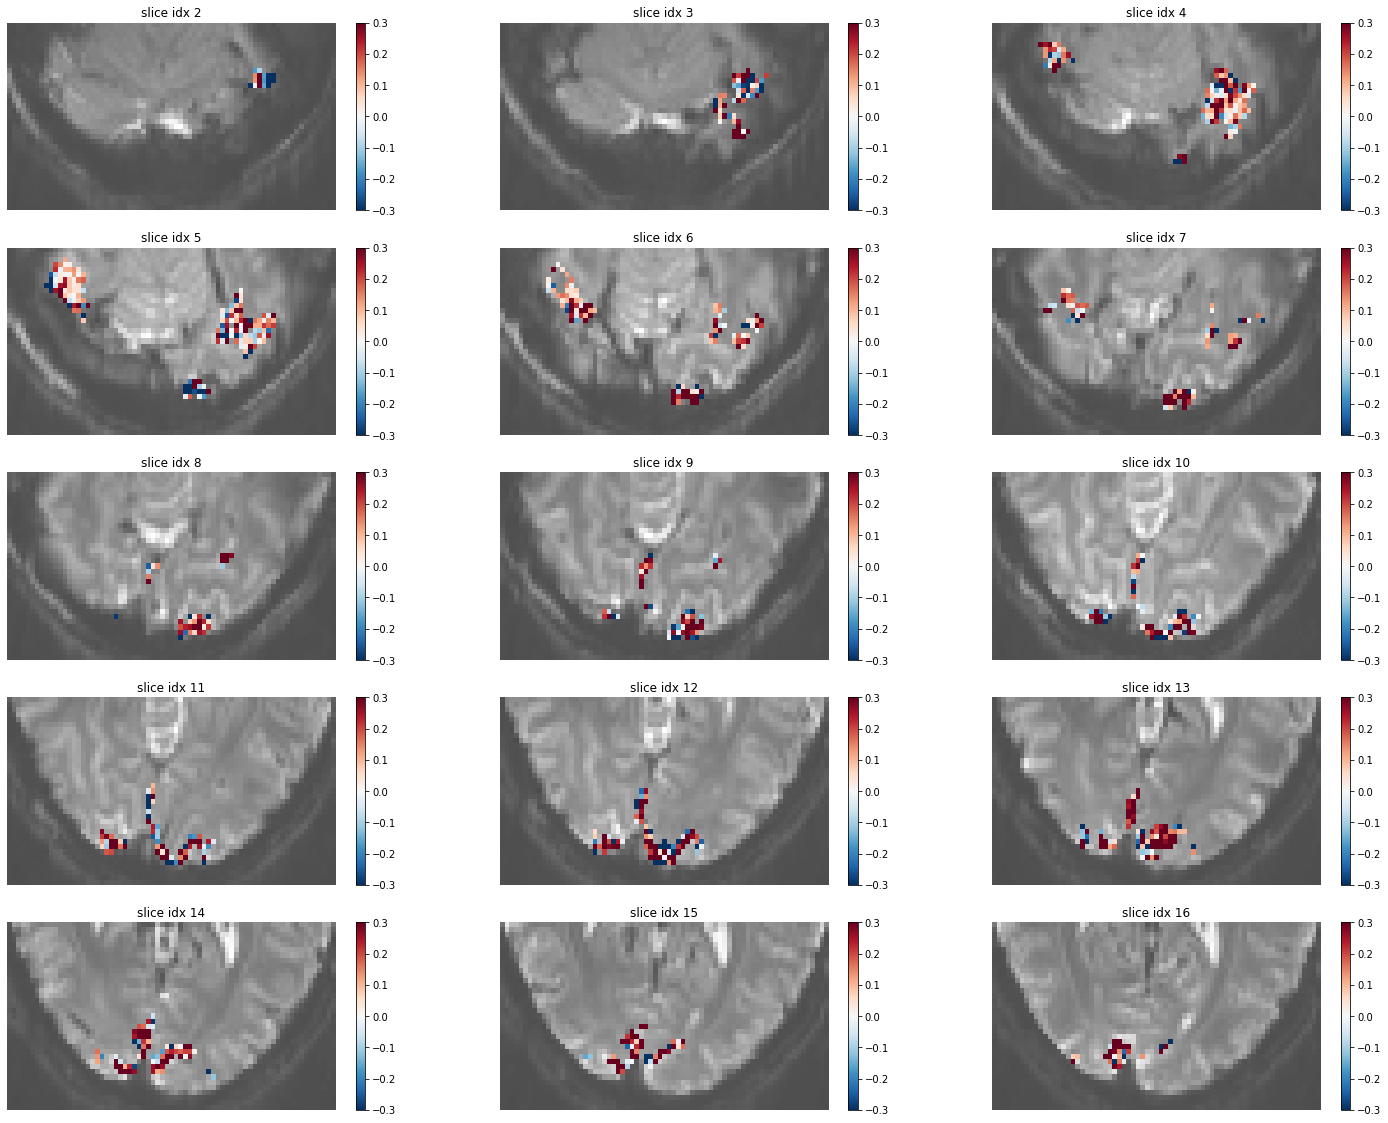

In [21]:
vox_improvement = vox_reliabilities[3] - vox_reliabilities[0]

plt.figure(figsize=(25,20))
c=1
for s in range(2,17):
    plt.subplot(5,3,c)
    plt.imshow(meanvol[15:,5:-5,s]/np.nanmax(meanvol[15:,5:-5,s]),aspect='auto',cmap='gray',clim=(0,1), alpha=0.7)
    plt.imshow(vox_improvement[15:,5:-5,s],aspect='auto',cmap='RdBu_r',clim=(-0.3,0.3))
    plt.title('slice idx ' + str(s))
    plt.colorbar()
    plt.box(False)
    plt.axis(False)
    c+=1